In [1]:
!pip install tensorflow==2.3.0

Looking in indexes: http://192.168.0.94:8888/repository/pypi/simple
     |████████████████████████████████| 320.4 MB 98.9 MB/s eta 0:00:011     |████████████▌                   | 125.1 MB 105.1 MB/s eta 0:00:02
     |████████████████████████████████| 2.9 MB 94.7 MB/s eta 0:00:01
     |████████████████████████████████| 20.1 MB 80.6 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 87.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 87.5 MB/s eta 0:00:01
     |████████████████████████████████| 459 kB 82.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 73.9 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 76.0 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
   

In [1]:
from siamese_embeddings import *

2023-09-12 11:46:47.084931: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/home/ma-user/anaconda3/envs/TensorFlow-2.1/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#import pickle
#next to evaluate 
#c_minds/models/model_1024_vgg16_latent_space2023-09-07_12:24:39.hdf5
##################################



# Assuming you've trained your model and want to save its convolutional layers' weights
#model_path = "models/model_1024_vgg16_latent_space2023-09-07_11:07:40.hdf5"  # Modify this with the actual path
model_path = "models/model_1024_vgg16_latent_space2023-09-07_12:24:39.hdf5"
#ce2023-09-07_12:24:39.hdf5"  # Modify this with the actual path


#import pickle

# Assuming you've trained your model and want to save its convolutional layers' weights
#model_path = "path_to_your_model.hdf5"  # Modify this with the actual path

# Load the model weights without compiling the model
loaded_base_model =  initialize_base_branch_vgg16_latent_space()
loaded_base_model.load_weights(model_path, by_name=True)

2023-09-12 11:47:02.205198: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-09-12 11:47:02.308708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 11:47:02.312497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:0d.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-12 11:47:02.312532: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-09-12 11:47:02.314434: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-09-12 11:47:02.316173: I tensorflow/stream_executor/platfo

58892288/58889256 [==============================] - 4s 0us/step


In [3]:
loaded_base_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


In [6]:
loaded_base_model.inputs

[<tf.Tensor 'base_input:0' shape=(None, 224, 224, 3) dtype=float32>]

In [7]:
loaded_base_model.get_layer("latent").output

<tf.Tensor 'latent/Relu:0' shape=(None, 7, 7, 512) dtype=float32>

In [8]:
loaded_base_model.output

<tf.Tensor 'IMGembedding/BiasAdd:0' shape=(None, 1024) dtype=float32>

In [9]:
#def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
img_size = (224, 224)
last_conv_layer_name = "latent"
img_path =  "jaguar.jpeg" 
img_array = get_img_array(img_path,size=img_size)


grad_model = tf.keras.models.Model(
    [loaded_base_model.inputs], [loaded_base_model.get_layer(last_conv_layer_name).output, loaded_base_model.output])

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    #if pred_index is None:
    #pred_index = tf.argmax(preds[0])
    class_channel = preds



2023-09-12 11:48:53.975804: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2023-09-12 11:48:55.117132: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [12]:
# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap.numpy()


array([[0.4239447 , 0.2671132 , 0.49656478, 0.08675521, 0.18702783,
        0.11550332, 0.21065506],
       [0.62328947, 1.        , 0.57637495, 0.0286033 , 0.        ,
        0.03184436, 0.        ],
       [0.5248243 , 0.9905506 , 0.5353491 , 0.        , 0.0429561 ,
        0.07094333, 0.03932912],
       [0.20491298, 0.5088355 , 0.41573724, 0.26787892, 0.2786899 ,
        0.41532093, 0.24794182],
       [0.        , 0.        , 0.30190954, 0.6415262 , 0.398899  ,
        0.26304775, 0.14855203],
       [0.14050786, 0.        , 0.        , 0.15601526, 0.18136032,
        0.31544763, 0.4143978 ],
       [0.11730599, 0.2685573 , 0.23091236, 0.22005272, 0.11908789,
        0.09184097, 0.2638347 ]], dtype=float32)

In [10]:
heatmap.shape

TensorShape([7, 7])

In [10]:
from PIL import Image


In [11]:
import matplotlib.cm as cm
from IPython.display import Image, display
import matplotlib.pyplot as plt
import cv2


In [27]:
preds[0].tolist()

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'tolist'

In [18]:
[x for x in preds.numpy()[0]]

[2.023556,
 1.876731,
 -0.7374572,
 -2.6322563,
 -7.5773997,
 -10.780199,
 -6.105257,
 5.912175,
 -1.0179734,
 4.4048557,
 6.3916416,
 6.566807,
 -4.934179,
 -6.882954,
 6.867508,
 -16.506851,
 -7.6515937,
 -0.024819732,
 4.914464,
 -7.002838,
 -2.480114,
 4.111698,
 -4.126899,
 2.1104524,
 0.41381085,
 -2.4562173,
 -15.142294,
 -5.025318,
 11.25286,
 12.016275,
 -1.0398204,
 -0.3353628,
 -7.8896246,
 -2.5656595,
 -0.52141,
 6.379978,
 10.880909,
 -8.089925,
 -4.641244,
 9.059998,
 -4.4837193,
 2.3169718,
 -3.5970335,
 12.48137,
 0.8257165,
 1.089879,
 0.7016082,
 -2.149201,
 8.271233,
 -9.743387,
 -7.8532867,
 3.8785725,
 -4.433635,
 2.930431,
 -6.8500237,
 -9.561788,
 2.8747487,
 3.0062304,
 -4.4153657,
 6.014394,
 -9.803484,
 2.667354,
 6.297501,
 -0.47681373,
 10.822765,
 1.6574959,
 -2.1822433,
 -4.5477715,
 8.202,
 -5.4751787,
 -7.7830534,
 6.4501762,
 0.2069478,
 0.9569248,
 0.59292626,
 3.5697234,
 -6.1742153,
 1.907731,
 -3.133784,
 6.5168076,
 -5.76543,
 -8.054638,
 3.2852023

In [30]:
#def display_gradcam_mask(img_path,ax,heatmap, cam_path="cam.jpg", alpha=0.4):
# Load the original image
# we want the image to be 224x224x3
heatmap =heatmap.numpy()

img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("inferno")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

#lets make an array 
#arr_mask = np.array(jet_heatmap)

# Superimpose the heatmap on original image
#superimposed_img = jet_heatmap * alpha + img
#superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
#superimposed_img.save(cam_path)

# Display Grad CAM
#display(Image(cam_path))
#superimposed_img.show()
jet_heatmap.imshow()  

#ave_and_display_gradcam(img_path, heatmap,alpha=1)

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

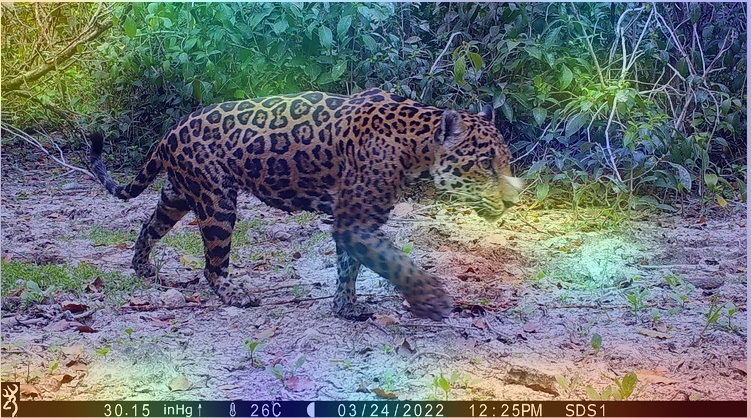

In [35]:
alpha=0.4
# Load the original image
# we want the image to be 224x224x3
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * alpha + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
#superimposed_img.save(cam_path)

# Display Grad CAM
#display(Image(cam_path))
superimposed_img.show()
#x.imshow(mask_image)

In [37]:
type(superimposed_img)

PIL.Image.Image

In [19]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    # we want the image to be 224x224x3
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    superimposed_img.show()
    #x.imshow(mask_image)  

#ave_and_display_gradcam(img_path, heatmap,alpha=1)

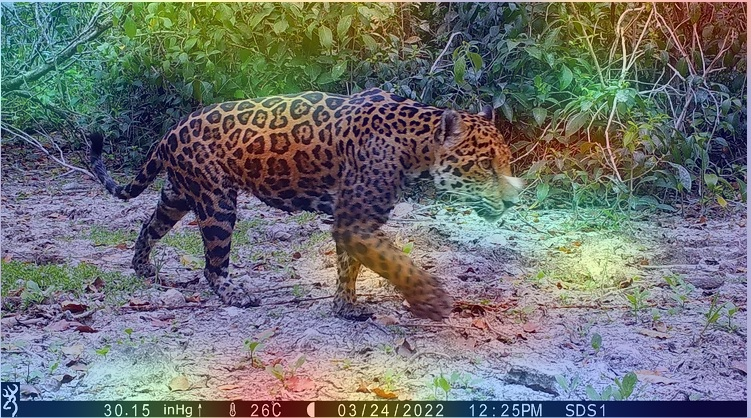

In [20]:
save_and_display_gradcam(img_path, heatmap)

# Gradient Cam 

So far we were able to visualize a heat map 
that can show what the model is taking into 
consideration at the moment of what it is 
extracting from the image. 



# Class Gradient Cam Siamese 

This Class aims to help in visualizing the gradient cam 
for the task of identifying individuals.

we have been working with siamese network using triplet loss.
the network is using three image for the training phase, in this case it has 
Anchor: the base image 
Positive: an example of the same indv as the anchor 
Negative: A different indv 

However for the prediction task we are loading the model that 
produces the embedding only 

then we create a gradient cam based on that model. 

In [5]:

class Gradient_cam_siamese():

    def __init__(self, model,last_conv_layer_name,img_size):
        self.grad_model = self.grad_model(model)
        self.last_conv_layer_name= last_conv_layer_name
        self.img_size= img_size
        
        
    def grad_model(self,loaded_base_model):
        return tf.keras.models.Model([loaded_base_model.inputs], [loaded_base_model.get_layer(last_conv_layer_name).output, loaded_base_model.output])
    
    def get_img_array(self,img_path):
        # `img` is a PIL image of size 299x299
        img = keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
        # `array` is a float32 Numpy array of shape (299, 299, 3)
        array = keras.preprocessing.image.img_to_array(img)
        # We add a dimension to transform our array into a "batch"
        # of size (1, 299, 299, 3)
        array = np.expand_dims(array, axis=0)
        return array
    
    def make_heatmap(self,img_path):
        img_array = self.get_img_array(img_path)
        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = self.grad_model(img_array)
            #if pred_index is None:
            #pred_index = tf.argmax(preds[0])
            class_channel = preds



        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    
    #This function need to be according to the flask app 
    #it output the heatmap and the embedding 
    #so far in the app we have the data as array untill this point 
    #
    #
    #
    def calculate_heatmap_embedding_gradcam(self,img_path,alpha=0.4):
        #get the heatmap 
        heatmap = self.make_heatmap(img_path)
        # Load the original image
        img = keras.preprocessing.image.load_img(img_path,target_size=(224,224,3))
        img = keras.preprocessing.image.img_to_array(img)

        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        # Save the superimposed image
        #superimposed_img.save(cam_path)

        # Display Grad CAM
        display(Image(cam_path))

    
    
    
    def save_and_display_gradcam(self,img_path,cam_path="cam.jpg",alpha=0.4):
        #get the heatmap 
        heatmap = self.make_heatmap(img_path)
        # Load the original image
        img = keras.preprocessing.image.load_img(img_path,target_size=(224,224,3))
        img = keras.preprocessing.image.img_to_array(img)

        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        # Save the superimposed image
        superimposed_img.save(cam_path)

        # Display Grad CAM
        display(Image(cam_path))

        

        

In [25]:
# Lets start using the new class for image visualization. 
img_size = (224, 224)
last_conv_layer_name = "latent"
img_path =  "jaguar.jpeg"

grad_cam_vis = Gradient_cam_siamese(loaded_base_model,last_conv_layer_name,img_size)

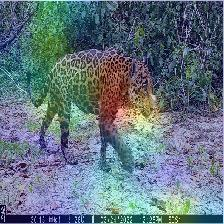

In [28]:
grad_cam_vis.save_and_display_gradcam(img_path)

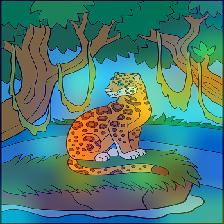

In [31]:
grad_cam_vis .save_and_display_gradcam("98889393-cartoon-animals-for-kids-cute-jaguar-sits-on-the-grass.jpg")

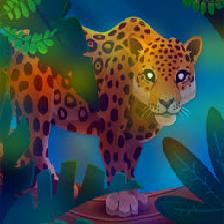

In [33]:
grad_cam_vis.save_and_display_gradcam("images.jpeg")

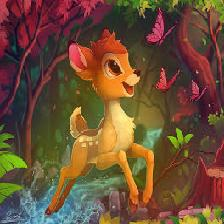

In [95]:
exported_grad_cam_vis.save_and_display_gradcam("images (1).jpeg")

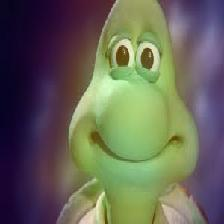

In [96]:
exported_grad_cam_vis.save_and_display_gradcam("images (2).jpeg")

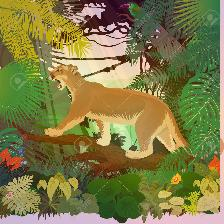

In [97]:
exported_grad_cam_vis.save_and_display_gradcam("109201769-puma-puma-puma-concolor-o-león-de-montaña-y-tucanet-de-rabadilla-carmesí-en-la-selva-tropical.jpg")

In [12]:
import pandas as pd 


In [13]:
df = pd.read_csv("csvs/phase2_processing_ext.csv")
df

,Unnamed: 0,annotation,usage,source,id,sample-type,img,xml,img_state,xmin,ymin,xmax,ymax,label
0,0,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM026 Darwin...,0012d9931ab1a96ccede6a26ced20fa2,0,indv_prona/JM026 Darwin/436964_2362703_2021 (3...,annotation/V001/annotations/JM026 Darwin/43696...,usefull,6,206,468,488,jaguar
1,1,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM012 Deo/JM...,002193526a1f1ab7f402e065fae566d9,0,indv_prona/JM012 Deo/JM012 Deo_original_436798...,annotation/V001/annotations/JM012 Deo/JM012 De...,usefull,872,759,1488,1939,jaguar
2,2,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JH014 Yeimy/...,002e972b91574250a58646f25dd73d3b,0,indv_prona/JH014 Yeimy/437129_2360603_2022 (26...,annotation/V001/annotations/JH014 Yeimy/437129...,usefull,248,275,806,517,jaguar
3,3,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JH002 Chanti...,00393cfce0d7ea9b88cd283a53ff33d4,0,indv_prona/JH002 Chantico/JH002 Chantico_origi...,annotation/V001/annotations/JH002 Chantico/JH0...,usefull,311,16,2575,1645,jaguar
4,4,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM026 Darwin...,004d528102b088a895e1f3bb50422ebf,0,indv_prona/JM026 Darwin/436879_2359092_2021 (3...,annotation/V001/annotations/JM026 Darwin/43687...,usefull,1204,500,2561,1535,jaguar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642,5073,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM025 Ramón/...,b5bf19054942b12ea9d3a8fe08658403,0,indv_prona/JM025 Ramón/JM025 Ramón_original_V_...,annotation/V001/annotations/JM025 Ramón/JM025 ...,usefull,0,0,1085,715,jaguar
4643,5074,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM002 Pantal...,b5c59e37a75101edead56a2fa8a28459,0,indv_prona/JM002 Pantalones/437086_2362819_EL ...,annotation/V001/annotations/JM002 Pantalones/4...,usefull,892,535,1242,762,jaguar
4644,5075,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM023 Macari...,b5d5c59c882523deb2f1b632022ef3d9,0,indv_prona/JM023 Macario/JM023 Macario_origina...,annotation/V001/annotations/JM023 Macario/JM02...,usefull,0,447,680,1548,jaguar
4645,5076,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM007 Othelo...,b5d6c680a22e7504d12ff3de12d3865e,0,indv_prona/JM007 Othelo/JM007 Othelo_original_...,annotation/V001/annotations/JM007 Othelo/JM007...,usefull,964,581,1997,1446,jaguar


In [14]:
df["label"].unique()

array(['jaguar'], dtype=object)

In [15]:
df2 = df.query("label == 'jaguar'")
df2

,Unnamed: 0,annotation,usage,source,id,sample-type,img,xml,img_state,xmin,ymin,xmax,ymax,label
0,0,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM026 Darwin...,0012d9931ab1a96ccede6a26ced20fa2,0,indv_prona/JM026 Darwin/436964_2362703_2021 (3...,annotation/V001/annotations/JM026 Darwin/43696...,usefull,6,206,468,488,jaguar
1,1,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM012 Deo/JM...,002193526a1f1ab7f402e065fae566d9,0,indv_prona/JM012 Deo/JM012 Deo_original_436798...,annotation/V001/annotations/JM012 Deo/JM012 De...,usefull,872,759,1488,1939,jaguar
2,2,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JH014 Yeimy/...,002e972b91574250a58646f25dd73d3b,0,indv_prona/JH014 Yeimy/437129_2360603_2022 (26...,annotation/V001/annotations/JH014 Yeimy/437129...,usefull,248,275,806,517,jaguar
3,3,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JH002 Chanti...,00393cfce0d7ea9b88cd283a53ff33d4,0,indv_prona/JH002 Chantico/JH002 Chantico_origi...,annotation/V001/annotations/JH002 Chantico/JH0...,usefull,311,16,2575,1645,jaguar
4,4,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM026 Darwin...,004d528102b088a895e1f3bb50422ebf,0,indv_prona/JM026 Darwin/436879_2359092_2021 (3...,annotation/V001/annotations/JM026 Darwin/43687...,usefull,1204,500,2561,1535,jaguar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4642,5073,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM025 Ramón/...,b5bf19054942b12ea9d3a8fe08658403,0,indv_prona/JM025 Ramón/JM025 Ramón_original_V_...,annotation/V001/annotations/JM025 Ramón/JM025 ...,usefull,0,0,1085,715,jaguar
4643,5074,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM002 Pantal...,b5c59e37a75101edead56a2fa8a28459,0,indv_prona/JM002 Pantalones/437086_2362819_EL ...,annotation/V001/annotations/JM002 Pantalones/4...,usefull,892,535,1242,762,jaguar
4644,5075,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM023 Macari...,b5d5c59c882523deb2f1b632022ef3d9,0,indv_prona/JM023 Macario/JM023 Macario_origina...,annotation/V001/annotations/JM023 Macario/JM02...,usefull,0,447,680,1548,jaguar
4645,5076,"[{'annotation-format': 'PASCAL VOC', 'type': '...",train,s3://bucket-beta-test/indv_prona2/JM007 Othelo...,b5d6c680a22e7504d12ff3de12d3865e,0,indv_prona/JM007 Othelo/JM007 Othelo_original_...,annotation/V001/annotations/JM007 Othelo/JM007...,usefull,964,581,1997,1446,jaguar


In [23]:
df.iloc[:10,6].values

array(['indv_prona/JM026 Darwin/436964_2362703_2021 (38) 10.jpg',
       'indv_prona/JM012 Deo/JM012 Deo_original_436798_2359121_NLsitio 03_B_2013_1236 JM-7a (1)(1).JPG_6368451e-7374-47ea-a501-6e05e9852be9.JPG',
       'indv_prona/JH014 Yeimy/437129_2360603_2022 (265).jpg',
       'indv_prona/JH002 Chantico/JH002 Chantico_original_436038_2362290_b05sitio5_A_2013_115.JPG_d5ce6402-75cb-41c7-a65c-99a4b4dc924d.JPG',
       'indv_prona/JM026 Darwin/436879_2359092_2021 (34).JPG',
       'indv_prona/JM014 Sabino/JM014 Sabino_original_santamaria_SITIO 13_2014_R4.1_2371 JM-10.JPG_cdab0518-24cd-46dc-9266-3e45f6300849.JPG',
       'indv_prona/JM014 Sabino/V__00005 011.jpg',
       'indv_prona/JH001 Gaia/JH001 Gaia_original_438683_2362145_Trampa 21 Z1_2004PoH015.jpg_0918f413-5ab1-437d-af99-91444b57c74e.jpg',
       'indv_prona/JH002 Chantico/JH002 Chantico_original_436798_2359121_NLsitio 03_B_2013_1236 JM-7a (2)(1).JPG_4e3c92da-dd55-4ac3-ab5c-54acf4cdb4e7.JPG',
       'indv_prona/JM028 David/43412

indv_prona/JM031 Nicolas/JM031 Nicolas_original_Captura 2.PNG_9d720c2e-089f-4f61-b44b-de6e4d7e979c.PNG


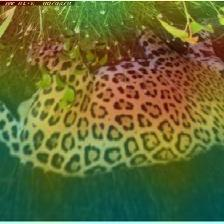

indv_prona/JM010 Pepe/JM010 Pepe_original_436042_236290_2007_F3_C3_FOLIO_183.jpg_7256cd4a-8134-4393-99a0-2e3770681334.jpg


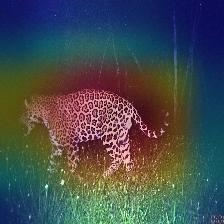

indv_prona/JM014 Sabino/JM014 Sabino_original_V__00005 011.jpg_80503b4f-c239-4219-b458-d8d31177b78d.jpg


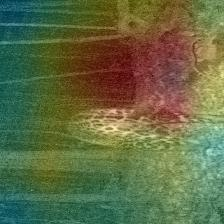

indv_prona/JM031 Nicolas/JM031 Nicolas_original_Captura 1.PNG_e2dc60f0-e581-492e-a936-286da0be307b.PNG


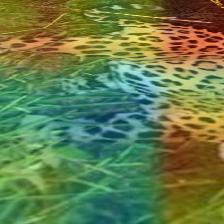

indv_prona/JD005/JD005_original___00001.JPG_54598b1b-2529-4246-b402-e8b0baf6950f.JPG


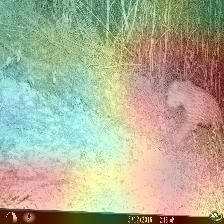

indv_prona/JH008 Olivia/JH008 Olivia_original_439852_2363212_2022 (32) 06.jpg_3bf2ea5f-af49-4639-accf-9481194ea735.jpg


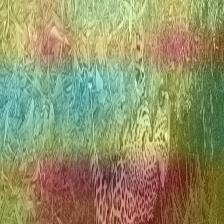

indv_prona/JH004 Calista/JH004 Calista_original_nuevoleon_ML01B01_2013_R6_Panthera onca. M8 005.jpg_2a49e443-048d-4767-aee1-08392992ad54.jpg


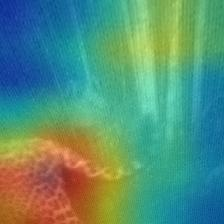

indv_prona/JM0027 Bakary/JM0027 Bakary_original_437275_2363102_2022 (6).JPG_a81bfda9-bb2c-47d1-accf-8061a8c0c6bd.JPG


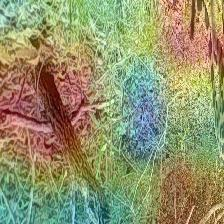

indv_prona/JH009 Camelia/JH009 Camelia_original_I__00040.JPG_3cc74441-b2ad-4e55-95b6-39f43040547e.JPG


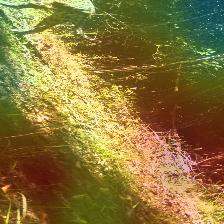

indv_prona/JM014 Sabino/JM014 Sabino_original_V__00015 010.jpg_dd0b5a09-6b00-4ea5-a2d6-ba2a6c007573.jpg


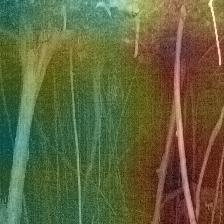

indv_prona/JM017 Draco/SITIO_3_2015_R1_00002 016.jpg


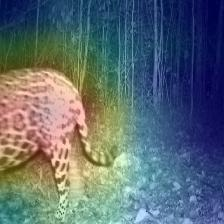

indv_prona/JM013 Darius/JM013 Darius_original_santamaria_SITIO 13_2014_R5.1_2447 JM-8.JPG_fc09f4f9-3d3a-4a6a-b03f-5e43b381d106.JPG


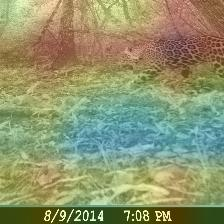

indv_prona/JD002/JD002_original_GetImage3.jpeg_51259f30-7402-4b19-b013-7e21de4d670e.jpeg


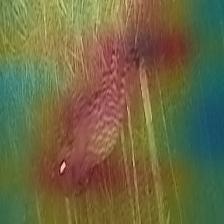

indv_prona/JM029 Dongo/JM029 Dongo_original_Captura.PNG_51fa6754-e1d9-48fb-9a9f-2e811afd568a.PNG


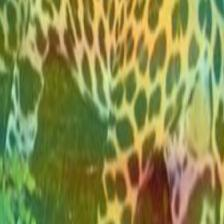

indv_prona/JM016 Lupin/JM016 Lupin_original_nuevoleon_sitio 19_2_2014_R4_2592 JM-15.JPG_59ee10fd-47d6-425d-835c-612c610f9d0f.JPG


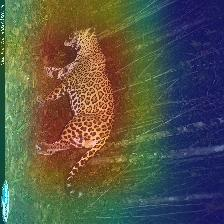

indv_prona/JM018 Yaxkin/JM018 Yaxkin_original_SITIO_1_2015_R1_Cdy00003(2).JPG_d9ace81f-59b4-4d7a-b591-c34d06dbd521.JPG


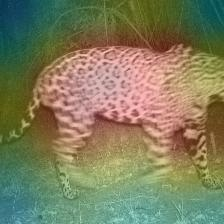

indv_prona/JH008 Olivia/V__00013 255.jpg


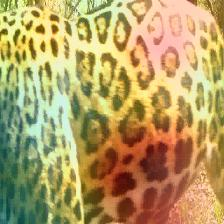

indv_prona/JD001/JD001_original_441146_2362003_b07sitio2_2013_666.JPG_37295da9-7a09-44ba-87f0-a116e846c53f.JPG


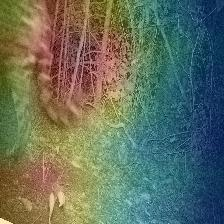

indv_prona/JM018 Yaxkin/JM018 Yaxkin_original_NL_4_2015_R2_2868 jag problema.JPG_9ff812d4-0086-4674-a75a-d1ddc70dfe0a.JPG


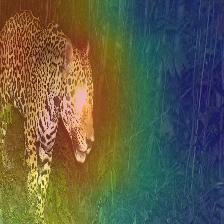

indv_prona/JM027 Bakary/JM027 Bakary_original_436964_2362703_2021 (7).JPG_b952ad28-6496-44f8-ab36-9ec3c231f671.JPG


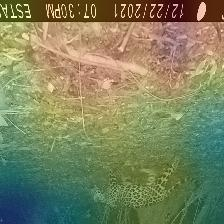

indv_prona/JD002/JD002_original_GetImage.jpeg_efe09454-3221-4870-bbdd-0518296b3d6a.jpeg


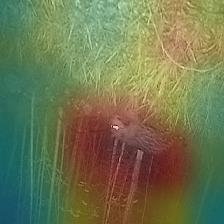

indv_prona/JM014 Sabino/JM014 Sabino_original_SM_3_2_2015_R1_2719 JM_10.JPG_fa9cd59c-3b5f-41d1-b18f-feb1671a2f85.JPG


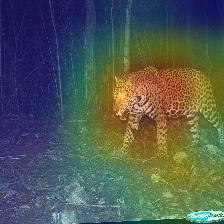

indv_prona/JH004 Calista/JH004 Calista_original_nuevoleon_ML01B01_2013_R6_Panthera onca. M8 02.jpg_10a34700-242f-4d1d-8232-09a2a17e4d8d.jpg


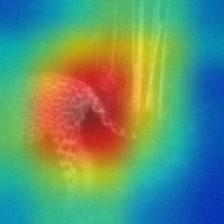

indv_prona/JM015 Manotas/JM015 Manotas_original_JZ12-M8.JPG_e868eeac-af22-4876-9206-0b56e778475b.JPG


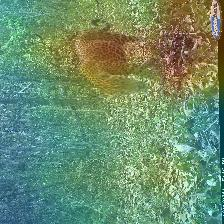

indv_prona/JH006 Pía/JH006 Pía_original_I__00008.JPG_b980dc23-f29d-49d1-975c-e1dfb0189620.JPG


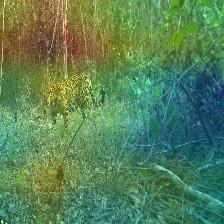

indv_prona/JD008/JD008_original_JZAP07-M3.JPG_b5c4648a-6ecf-401f-816a-e929f21f3120.JPG


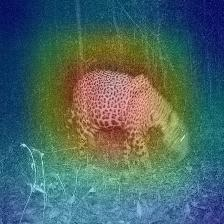

indv_prona/JM011 Goliat/JM011 Goliat_original_goliat.PNG_f0bc23be-91be-4c5c-bbba-63e0ce0dd7c5.PNG


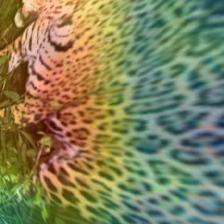

indv_prona/JH002 Chatinco/JH002 Chatinco_original_SITIO_10_2015_R2_PICT0002 08.jpg_f70a782b-7418-445a-a485-0206c7a76e72.jpg


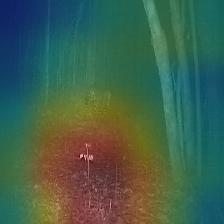

indv_prona/JM002 Pantalones/JM002 Pantalones_original_438683_2362145_Trampa 21 Z1_2004PoM004.jpg_ddaab13e-0ec8-463d-b78b-0f060038118f.jpg


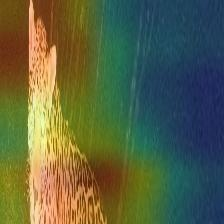

indv_prona/JM026 Darwin/JM026 Darwin_original_439329_2363176_2022 (740).JPG_c31f6dee-afb4-433f-a975-b5135da91ca4.JPG


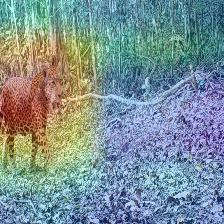

indv_prona/JM012 Deo/JM012 Deo_original_nuevoleon_NL02B02_2013_R6_1345 JM-7.JPG_2a810b5b-9233-4fd9-9f82-561e1d855812.JPG


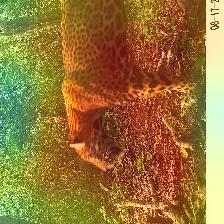

indv_prona/JH012 Dara/JH012 Dara_original_PICT0146 0588.jpg_c6ecb7fb-de0b-4fbd-b244-8246f5e91d21.jpg


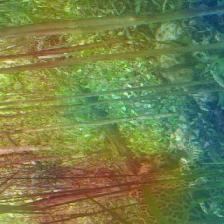

indv_prona/JD001/JD001_original_444238_2362238_sitio1b01_B_2013_1376-1 JM-6.JPG_efce74dd-a5af-4433-8395-1fa9a403dc7b.JPG


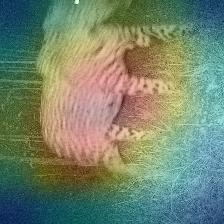

indv_prona/JH012 Dara/PICT0139 1717.jpg


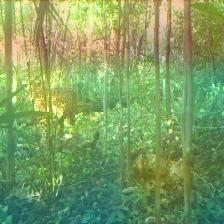

indv_prona/JH012 Padme/439329_2363176_2021 (879).JPG


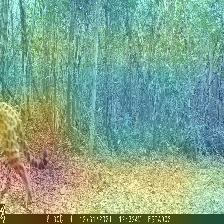

indv_prona/JM013 Darius/JM013 Darius_original_439188_2357526_2014 (1).JPG_c136d186-4d81-4182-b0d6-710dc0781dd0.JPG


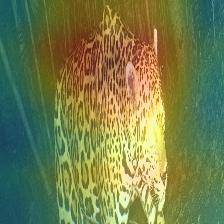

indv_prona/JM009 Titan/JM009 Titan_original_elzapotal_ZAP07B07_2013_R5V_Panthera onca. M1.JPG_a7777f90-13c7-46ee-bdfa-e756010f1655.JPG


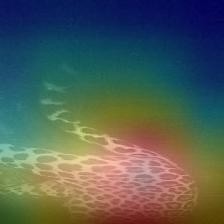

indv_prona/JM0027 Bakary/JM0027 Bakary_original_439329_2363176_2022 (392) 01.jpg_7a249aee-7734-40f6-872e-fb8e9cf196a4.jpg


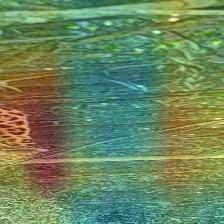

indv_prona/JH003 Maia/JH003 Maia_original_JZ02-H2.JPG_54b335bc-bdfb-4734-860e-3a3f25266f37.JPG


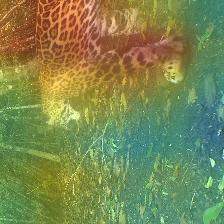

indv_prona/JM015 Monotas/JM015 Monotas_original_elzapotal_ZAP03CUDE03_2013_R5_430 JM-12.JPG_c26a0888-0b6f-4d39-9da0-6a39e7c1a6e2.JPG


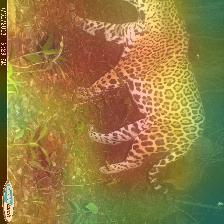

indv_prona/JM019 Charles/JM019 Charles_original_Cdy00011(1) 081.jpg_e8ef32d7-0381-4732-8856-56387b6dcde9.jpg


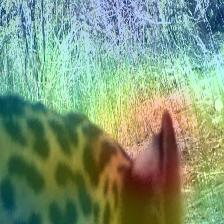

indv_prona/JM017 Draco/JM017 Draco_original_SITIO_3_2015_R1_00002 015.jpg_7c668c45-3739-47f9-aa27-23c2fc80efa9.jpg


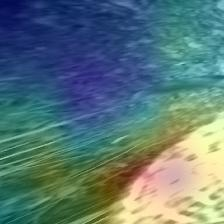

indv_prona/JH013 Leia/JH013 Leia_original_437129_2360603_2022 (268) 10.jpg_d14b28d6-d002-413e-9aa2-051cac680ceb.jpg


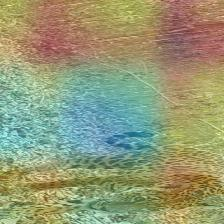

indv_prona/JM0027 Bakary/437275_2363102_2022 (6).JPG


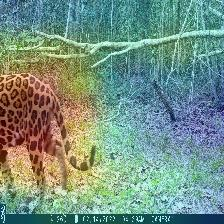

indv_prona/JM007 Othelo/JM007 Othelo_original_432893_2363278_Sitio B3_2005_432893_2363278_Jaguar_T37_25jun05.jpg_b6c84223-18f7-4be5-95ef-8f5dd82346eb.jpg


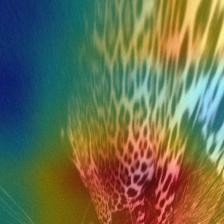

indv_prona/JD002/JD002_original_GetImage.jpeg_343ced8d-6a95-4311-8153-ebb3c51be534.jpeg


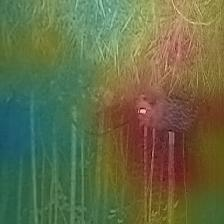

indv_prona/JM009 Titan/elzapotal_sitio2Cu02_2013_R2_234 JM-5.JPG


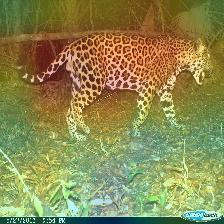

indv_prona/JM031 Nicolas/JM031 Nicolas_original_Captura 1.PNG_ba86102c-fbb4-46f8-a9fb-a7f0d7cf9d0a.PNG


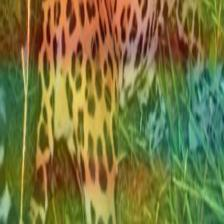

indv_prona/JM008 Hércules/JM008 Hércules_original_436042_2362090_SITIO A3_2006_F1_C1_FOLIO_128.jpg_ed392660-1535-4268-80c7-6228be8b5307.jpg


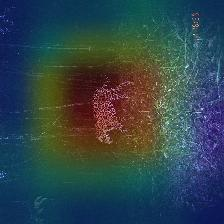

indv_prona/JM023 Macario/JM023 Macario_original_V__00041 022.jpg_f4e25bdf-534b-45dd-bd15-78c722e9b1b4.jpg


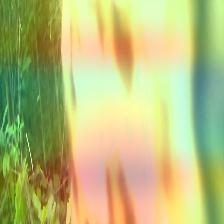

In [18]:
for i in df2.iloc[1700:1750,6].values:
    print(i)
    exported_grad_cam_vis.save_and_display_gradcam(i)

# Model exporting

So far we have deployed the gradient cam 
we have seen some examples that work pretty 
well I think.

Now we have we to export the model in a reusable way. 

In [83]:
grad_model.input

[<tf.Tensor 'base_input:0' shape=(None, 224, 224, 3) dtype=float32>]

In [84]:
grad_model.output

[<tf.Tensor 'latent/Relu:0' shape=(None, 7, 7, 512) dtype=float32>,
 <tf.Tensor 'IMGembedding/BiasAdd:0' shape=(None, 1024) dtype=float32>]

In [85]:
grad_model.save("models/grad_cam_siamese_latent_space.h5")

In [ ]:
model_33 = tf.load_mode

In [6]:
from tensorflow.keras.models import load_model


In [7]:
# load model
savedModel=load_model("models/grad_cam_siamese_latent_space.h5")
savedModel.summary()

2023-09-12 09:11:39.665884: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-09-12 09:11:39.854758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 09:11:39.857915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:0d.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-12 09:11:39.857958: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-09-12 09:11:39.859967: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-09-12 09:11:39.861593: I tensorflow/stream_executor/platfo

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [8]:
# Lets start using the new class for image visualization. 
img_size = (224, 224)
last_conv_layer_name = "latent"
img_path =  "jaguar.jpeg"

exported_grad_cam_vis = Gradient_cam_siamese(savedModel,last_conv_layer_name,img_size)

2023-09-12 09:12:53.533222: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2023-09-12 09:12:54.632431: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


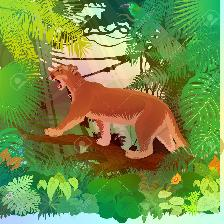

In [9]:
exported_grad_cam_vis.save_and_display_gradcam("109201769-puma-puma-puma-concolor-o-león-de-montaña-y-tucanet-de-rabadilla-carmesí-en-la-selva-tropical.jpg")

# Incorporating the model on the web application

For the model to be on the web 
we need to install it on the flask server. 
It is a container separately from the web server 

so lets figure it out how to use the model 
we have different levels of domain 


- app.py holds the main api functionality also has the routes

- model_pred.py has the functions to controll the models 

## creating new functions to predict. 

we need to define a new sequence to ouput the prediction 

In the API we define a new route to call the new model 
the ouput it produces is :
@app.route('/models/indvembed', methods = ["GET","POST"])

The function that will run the inference is 
def run_indv_inference(img_file):

it has to process the image it got a b64 image coded, 
def preprocess_img(img_file, tar_size):

it return a numpy array of the image as type float 

until here we have the data loaded and clean it. 
now we need to define the flow of the prediction

our model gets an image as input and return

- Image with heatmap 
- embedding


We need to modify the siamese class to work on the flask api 
In order to calculate the embedding and the heat map 


we need make a call to 

this function call 

calculate_heatmap_embedding_gradcam(self,img_path,alpha=0.4)

make_heatmap(self,img_path)

get_img_array(self,img_path)

In [ ]:

class Gradient_cam_siamese():
    #this function is adaptep to read images that are no saved 

    def __init__(self, model,last_conv_layer_name,img_size):
        self.grad_model = self.grad_model(model)
        self.last_conv_layer_name= last_conv_layer_name
        self.img_size= img_size
        
    #it creates the new model to predict     
    def grad_model(self,loaded_base_model):
        return tf.keras.models.Model([loaded_base_model.inputs], [loaded_base_model.get_layer(last_conv_layer_name).output, loaded_base_model.output])
    

    
    def preprocess_img(self,img_file):
        #Open the test image wit PIL and convert to 'RGB'
        #we need to take the input that is b64 
        #test_img= Image.open(img_file).convert('RGB')
        tar_size=224
        test_img = self.b64_to_PIL(img_file)
        #Resize the image withthe target size needed
        test_img = test_img.resize((tar_size, tar_size))
        #Transform img to array as type 'float32'
        test_img = np.array(test_img).astype('float32') / 255.0
        #Expand dims
        #test_img = np.expand_dims(test_img, axis=0)
        return test_img
    
    
    #we need to encapsulate the code into functions to be reusable. 
    def b64_to_PIL(self,data):
        """
        This function takes a b64 code and convert it 
        into PIL Image object, it reads the size of the imge 

        - Input: b64 information 
        - Output : w, h, img object  
        """
        im_bytes = base64.b64decode(data)   # im_bytes is a binary image
        im_file = BytesIO(im_bytes)  # convert image to file-like object
        img = Image.open(im_file) 
        #w, h = img.size

        return img 

    def make_heatmap(self,img_path):
        #img_array = self.get_img_array(img_path)
        #we got  img_path as b64 string 
        img_array = self.preprocess_img(img_path)
        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = self.grad_model(img_array)
            #if pred_index is None:
            #pred_index = tf.argmax(preds[0])
            class_channel = preds



        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy(),preds
    
    #This function need to be according to the flask app 
    #it output the heatmap and the embedding 
    #so far in the app we have the data as array untill this point 
    def calculate_heatmap_embedding_gradcam(self,img_path,alpha=0.4):
        #get the heatmap 
        heatmap,preds = self.make_heatmap(img_path)
        # Load the original image
        #img = keras.preprocessing.image.load_img(img_path,target_size=(224,224,3))
        #img = keras.preprocessing.image.img_to_array(img)
        img = preprocess_img(img_path)

        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        # Save the superimposed image
        #superimposed_img.save(cam_path)
        buffer = BytesIO()
        superimposed_img.save(buffer,format="JPEG")
        myimage = buffer.getvalue()
        nimg = base64.b64encode(myimage)

        # Display Grad CAM
        #display(Image(cam_path))
        return nimg,preds

    
    
    

